In [1]:
import pickle
import glob,os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, TimeSeriesSplit
from sklearn.pipeline import Pipeline
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import timedelta
import seaborn as sns

In [2]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id')

In [4]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

### Drop the unulual activity of Alice

In [5]:
train_df.drop(train_df[(train_df["target"]==1) & (train_df["time1"].dt.hour==14)].index,inplace=True)

In [6]:
train_df.drop(train_df[(train_df["target"]==1) & (train_df["time1"].dt.hour==11)].index,inplace=True)

### Create a spare matrix of sites

In [18]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]
full_sites = full_df[sites]

In [8]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

In [9]:
X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

### New features

In [5]:
new_features_train = pd.DataFrame(index = train_df.index)
new_features_test = pd.DataFrame(index =test_df.index)

Get Start_hour

In [6]:
1. #Start Hour
new_features_train["start_hour"] = train_df["time1"].apply(lambda ts: ts.hour)
new_features_test["start_hour"] = test_df["time1"].apply(lambda ts: ts.hour)

In [7]:
# 2. Morning
new_features_train["morning"] = np.where(new_features_train["start_hour"] <=11, 1,0)
new_features_test["morning"] = np.where(new_features_test["start_hour"] <=11, 1,0)

In [8]:
new_features_train["early_morning"] = np.where(new_features_train["start_hour"] < 9, 1, 0)
new_features_test["early_morning"] = np.where(new_features_test["start_hour"] < 9, 1, 0)

In [9]:
new_features_train["lunch"] = np.where(new_features_train["start_hour"]==14,1,0)
new_features_test["lunch"] = np.where(new_features_test["start_hour"]==14,1,0)

In [10]:
# 4. Evening
new_features_train["evining"] = np.where(new_features_train["start_hour"] > 18, 1, 0)
new_features_test["evining"] = np.where(new_features_test["start_hour"] > 18, 1, 0)
# best score so far on evining >22

In [11]:
new_features_train["month"] = train_df["time1"].dt.month
new_features_test["month"] = test_df["time1"].dt.month
month_train = pd.get_dummies(new_features_train["month"])
month_test = pd.get_dummies(new_features_test["month"])
month_train_new,month_test_new = month_train.align(month_test,join = "outer",axis = 1, fill_value = 0)

Day of week

In [12]:
new_features_train["day_of_week"] = train_df["time1"].dt.dayofweek
new_features_test["day_of_week"] = test_df["time1"].dt.dayofweek

In [13]:
new_features_train["work_holiday"] = np.where(new_features_train["day_of_week"].isin([0,1,2,3,4,5]),0,1)
new_features_test["work_holiday"] = np.where(new_features_test["day_of_week"].isin([0,1,2,3,4,5]),0,1)

In [19]:
start_hour = pd.concat([new_features_train["start_hour"],y_train],axis = 1)
#start_hour = start_hour[start_hour["target"]==1]

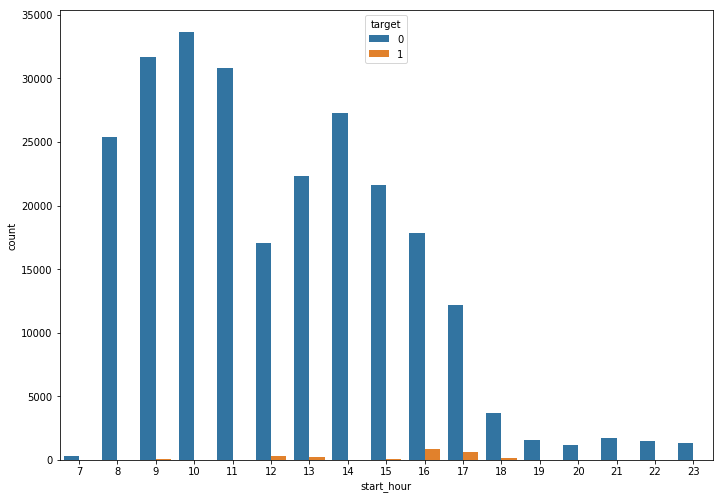

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(x = "start_hour", data = start_hour,hue = "target")

In [198]:
dayweek = pd.concat([new_features_train["day_of_week"],y_train],axis = 1)
dayweek = dayweek[dayweek["target"]==1]

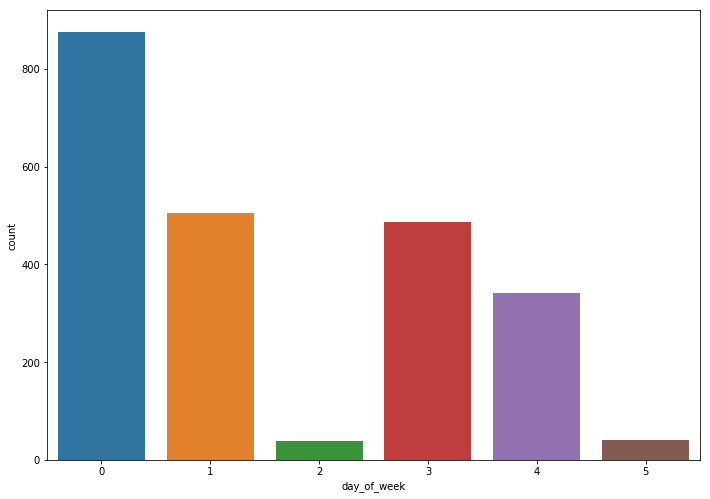

In [199]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(data = dayweek,x = "day_of_week")

In [69]:
month = pd.concat([train_df["time1"].dt.month,y_train],axis = 1)
month = month[month["target"]==1]

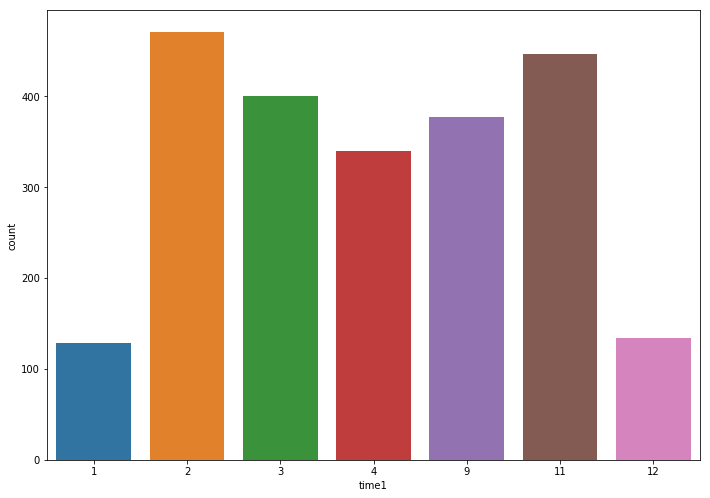

In [70]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(data = month,x = "time1")

In [71]:
day = pd.concat([train_df["time1"].dt.day,y_train],axis = 1)
day = day[day["target"]==1]

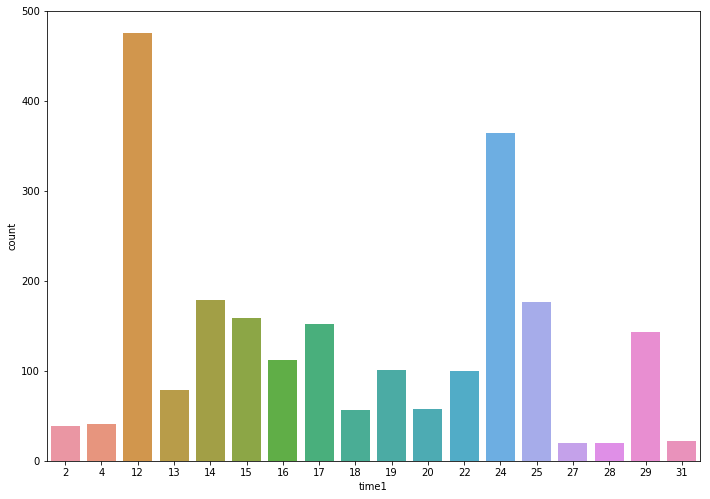

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(data = day,x = "time1")

In [89]:
month = pd.concat([new_features_train["month"],y_train],axis = 1)
month = month[month["target"]==1]

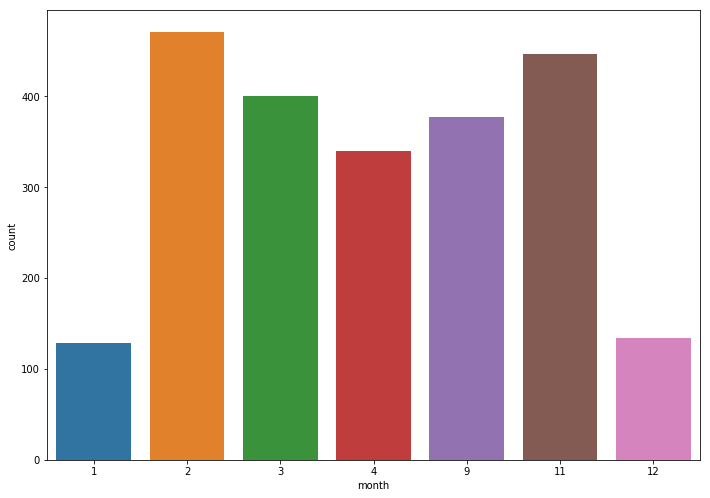

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(data = month,x = "month")

In [165]:
X_train_sparse_new = csr_matrix(hstack([X_train_sparse,
                                        csr_matrix(new_features_train["early_morning"].values.reshape(-1,1)),
                                        csr_matrix(new_features_train["morning"].values.reshape(-1,1)),
                                        csr_matrix(new_features_train["lunch"].values.reshape(-1,1)),
                                        csr_matrix(new_features_train["evining"].values.reshape(-1,1)),
                                        csr_matrix(new_features_train["work_holiday"].values.reshape(-1,1))
                                       ]))

In [166]:
X_test_sparse_new = csr_matrix(hstack([X_test_sparse,
                                       csr_matrix(new_features_test["early_morning"].values.reshape(-1,1)),
                                       csr_matrix(new_features_test["morning"].values.reshape(-1,1)),
                                       csr_matrix(new_features_test["lunch"].values.reshape(-1,1)),
                                        csr_matrix(new_features_test["evining"].values.reshape(-1,1)),
                                       csr_matrix(new_features_test["work_holiday"].values.reshape(-1,1))
                                    ]))

In [192]:
lr = LogisticRegression(random_state = 7,C = 0.08)

In [120]:
logit = cv.best_estimator_.predict_proba(X_test_sparse_new)[:,1]

In [194]:
write_to_submission_file(logreg,"logreg.csv")